# Tutorial 1: Training a spiking neural network with surrogate gradients

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

## Introduction 

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks that solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success that has raised both the bar and the question of how well this progress would translate to spiking neural networks.

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This development begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to these questions cannot be given at the moment, it seems that we can learn a lot.

In this tutorial, we use insights and tools from machine learning to build, step-by-step, a spiking neural network. Explicitly, we set out with the goal of building networks that solve (simple) real-world problems. To that end, we focus on classification problems and use supervised learning in conjunction with the aforementioned back-propagation algorithm. To do this, we have to overcome a vanishing gradient problem caused by the binary nature of the spikes themselves.

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to a discrete-time recurrent neural network (RNN). We will use this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in PyTorch.

## Mapping LIF neurons to RNN dynamics

The de-facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$
where $U_i$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. After having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$ 
for the spike train (ie. the sum of all spikes $C_i^l$ emitted by neuron $i$ in layer $l$). Here $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of the neuron.

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$
where we have introduced the synaptic weight matrices $W_{ij}$ (feed-forward), $V_{ij}$ (recurrent), and the synaptic decay time constant $\tau_\mathrm{syn}$.

To link to RNNs apparent, we will now express the above equations in discrete time. In the interest of brevity we switch to natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice, and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike, we start by noting that we can set
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$
where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by
$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$
with the constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$
with the output $S_i(t) = \Theta(U_i(t)-1)$ and the constant $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.



These equations can be summarized succinctly as the computational graph of an RNN with a specific connectivity structure. 
<img src="figures/snn_graph/snn_graph.png" width="450">
Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($S_i^{(0)}$). These inputs sequentially influence the synaptic currents $I_i^{(1)}$, membrane potentials the $U_i^{(1)}$, and finally the spiking output $S_i^{(1)}$.  Moreover, dynamic quantities have direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity.

The computational graph illustrates a concept which is known as unrolling in time, which emphasizes the duality between a deep neural network and a recurrent neural network, which is nothing more but a deep network in time (with tied weights). Due to this fact, we can train RNNs using the back-propagation of error through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now, let us start by implementing the above dynamics in a three-layer spiking neural network in PyTorch.

## Example network

In [1]:
import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import plotly.express as px

from model_components import (
    get_spike_fn, 
    get_default_dendritic_fn,
    get_sigmoid_fn,
    SpikingNetwork, 
    NeuronParameters,
    RecurrentSpikingNetwork,
    TwoCompartmentSpikingNetwork,
    RecurrentNeuronParameters,
    ParallelSpikingNetwork,
    PRCSpikingNetwork,
    PRCNeuronParameters,
    NetworkArchitecture,
    Environment
)
from optimizers import DefaultOptimizer

### A simple synthetic dataset 

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data, we fill a tensor of (Environment.batch_size x Environment.nb_steps x net.nb_units_by_layer[0]) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [2]:
network_architecture = NetworkArchitecture()

In [3]:
freq = 5  # Hz
prob = freq * Environment.time_step
mask = torch.rand(
    (Environment.batch_size, Environment.nb_steps, network_architecture.nb_units_by_layer[0]),
    device=Environment.device,
    dtype=Environment.dtype,
)
x_data = torch.zeros(
    (Environment.batch_size, Environment.nb_steps, network_architecture.nb_units_by_layer[0]),
    device=Environment.device,
    dtype=Environment.dtype,
    requires_grad=False,
)
x_data[mask < prob] = 1.0

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

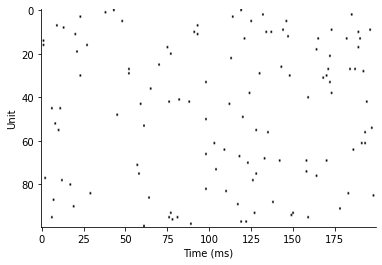

In [4]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [5]:
y_data = torch.tensor(
    1 * (np.random.rand(Environment.batch_size) < 0.5),
    device=Environment.device,
)

Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first, we fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some essential variables, including our $\alpha$ and $\beta$ as described above. We do this now because we will use some of these variables to scale our weights to meaningful ranges.

In [6]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=50):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        #ax.axis("off")

In [7]:
somatic_spike_fn = get_spike_fn(threshold=15)
dendritic_nl_fn = get_default_dendritic_fn(
    threshold=2, sensitivity=10, gain=1
)
neuron_params = RecurrentNeuronParameters(
    tau_mem=10e-3, 
    tau_syn=5e-3, 
    backprop_gain=0.5,
    feedback_strength=15,
    somatic_spike_fn=somatic_spike_fn, 
    dendritic_spike_fn=dendritic_nl_fn,
)

parallel_params = PRCNeuronParameters(
    tau_mem=10e-3,
    tau_syn=5e-3,
    backprop_gain=0.05,
    feedback_strength=15,
    somatic_spike_fn=somatic_spike_fn, 
    dend_na_fn=dendritic_nl_fn,
    dend_ca_fn=get_sigmoid_fn(
        threshold=4, sensitivity=10, gain=1
    ),
    dend_nmda_fn=dendritic_nl_fn,
    tau_dend_na=5e-3,
    tau_dend_ca=40e-3,
    tau_dend_nmda=80e-3,
)

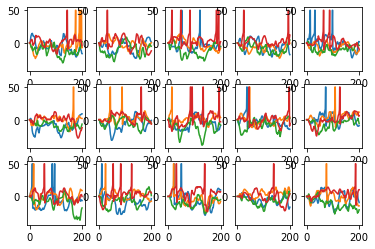

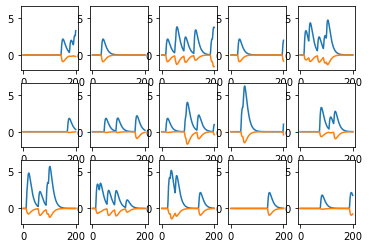

In [8]:
simple_network_architecture = deepcopy(network_architecture)
simple_network_architecture.weight_scale_by_layer = (140, 7)

simple_net = SpikingNetwork(
    neuron_params, simple_network_architecture
)

out, other_recordings = simple_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

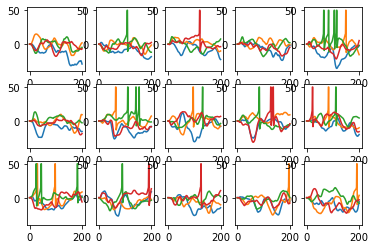

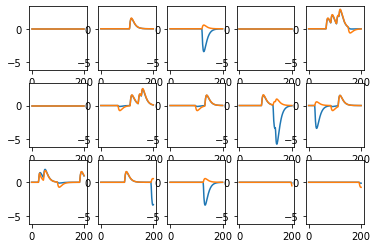

In [9]:
two_compartment_network_architecture = deepcopy(network_architecture)
two_compartment_network_architecture.weight_scale_by_layer = (15, 7)

two_compartment_net = TwoCompartmentSpikingNetwork(
    neuron_params, two_compartment_network_architecture
)

out, other_recordings = two_compartment_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

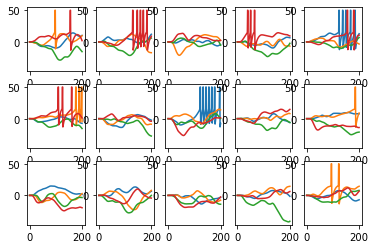

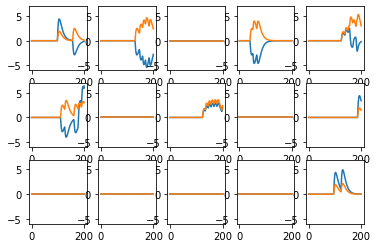

In [10]:
parallel_network_architecture = deepcopy(network_architecture)
parallel_network_architecture.weight_scale_by_layer = (1, 7)

parallel_net = ParallelSpikingNetwork(
    parallel_params, parallel_network_architecture
)

out, other_recordings = parallel_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

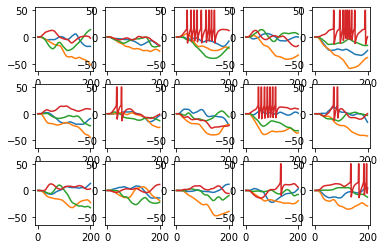

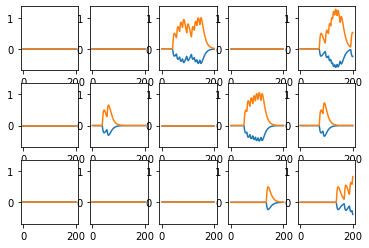

In [11]:
prc_net = PRCSpikingNetwork(
    parallel_params, parallel_network_architecture
)

out, other_recordings = prc_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

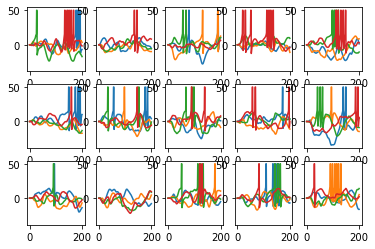

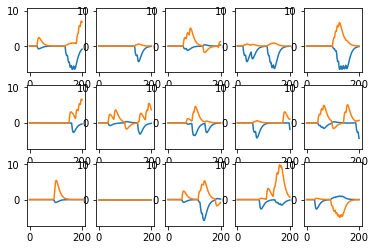

In [12]:
recurrent_net = RecurrentSpikingNetwork(
    neuron_params, two_compartment_network_architecture
)

out, other_recordings = recurrent_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

Show the classification accuracy before training. Should be close to 50%, since this is the chance level.

In [13]:
nets = {
    'One compartment': simple_net,
    'No BAP': two_compartment_net,
    'BAP': recurrent_net,
    'Parallel subunits, no BAP': parallel_net,
    'Parallel subunits + BAP (full PRC model)': prc_net
}

In [14]:
def classification_accuracy(net):
    """ Dirty little helper function to compute classification accuracy. """
    output,_ = net.run_snn(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    return acc

for label, net in nets.items():
    print(f'{label:<40} accuracy: {100*classification_accuracy(net):>4.1f}')

One compartment                          accuracy: 56.2
No BAP                                   accuracy: 43.0
BAP                                      accuracy: 44.9
Parallel subunits, no BAP                accuracy: 52.3
Parallel subunits + BAP (full PRC model) accuracy: 45.7


# Supervised learning

In [15]:
initial_weights = {
    label: net.weights_by_layer[0].detach()
    for label, net in nets.items()
}

In [16]:
optimizers = {
    label: DefaultOptimizer(
        lambda x: net.run_snn(x, reset=True)[0],
        net.weights_by_layer
    )
    for label, net in nets.items()
}

In [17]:
for label, optimizer in optimizers.items():
    print('-'*80)
    print(f'Training {label}')
    print(f'Accuracy before training: {100*classification_accuracy(nets[label]):>4.1f}%')
    optimizer.optimize(x_data, y_data, 30)
    print(f'Accuracy after training: {100*classification_accuracy(nets[label]):>5.1f}%')

--------------------------------------------------------------------------------
Training One compartment
Accuracy before training: 56.2%


  0%|          | 0/30 [00:00<?, ?it/s]

Accuracy after training:  56.2%
--------------------------------------------------------------------------------
Training No BAP
Accuracy before training: 43.0%


  0%|          | 0/30 [00:00<?, ?it/s]

Accuracy after training:  43.0%
--------------------------------------------------------------------------------
Training BAP
Accuracy before training: 44.9%


  0%|          | 0/30 [00:00<?, ?it/s]

Accuracy after training:  44.9%
--------------------------------------------------------------------------------
Training Parallel subunits, no BAP
Accuracy before training: 52.3%


  0%|          | 0/30 [00:00<?, ?it/s]

Accuracy after training:  52.3%
--------------------------------------------------------------------------------
Training Parallel subunits + BAP (full PRC model)
Accuracy before training: 45.7%


  0%|          | 0/30 [00:00<?, ?it/s]

Accuracy after training:  56.2%


Text(0, 0.5, 'Loss')

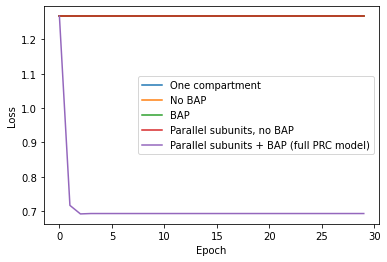

In [18]:
for label, optimizer in optimizers.items():
    plt.plot(optimizer.loss_history, label=label)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [21]:
initial_weights['One compartment'].weights_by_layer[0]

KeyError: 'One compartment'

In [20]:
nets['One compartment'].weights_by_layer[0]

tensor([[ 0.6583, -0.8923, -0.3048, -1.0284],
        [ 1.5051,  0.9272,  0.2292, -0.6885],
        [ 2.7102,  2.3263, -1.1093,  0.4800],
        [ 0.7445, -1.4789,  0.3247, -0.2875],
        [ 1.5791,  1.7349, -1.8637,  1.9811],
        [ 0.8753, -2.7208,  0.6017,  0.4222],
        [-2.1856,  1.1591, -1.5269, -1.2651],
        [-1.2215, -1.1465, -0.6620, -1.9757],
        [ 0.9558, -0.5908, -0.6852,  0.7658],
        [-1.9256, -1.0938, -0.2499, -2.1742],
        [-1.5715,  0.3085,  0.5249,  1.0775],
        [-1.0358, -1.1941, -3.2752,  0.2423],
        [-1.4327, -0.4621, -1.6189,  3.2535],
        [ 0.9162,  1.9527, -0.1300, -0.2319],
        [ 2.3766, -1.5567, -1.6233,  0.6372],
        [ 0.2681,  0.9264, -0.7159, -1.0725],
        [ 1.0423,  0.7850, -0.1150,  0.8928],
        [ 0.3664,  0.2724,  0.4685,  1.0542],
        [-2.0794,  0.1847, -1.6638, -0.0146],
        [-0.3089,  1.7390, -0.0799,  1.8249],
        [ 0.4176,  1.0380, -0.3253, -0.5720],
        [ 1.1189,  0.3692, -0.7460

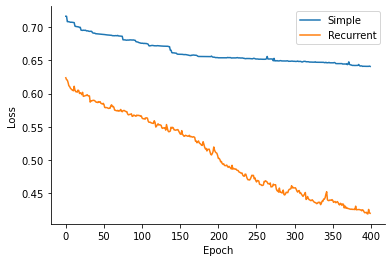

In [21]:
plt.plot(simple_optimizer.loss_history, label='Simple')
plt.plot(recurrent_optimizer.loss_history, label='Recurrent')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

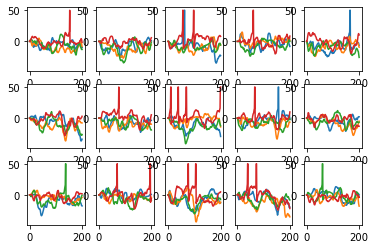

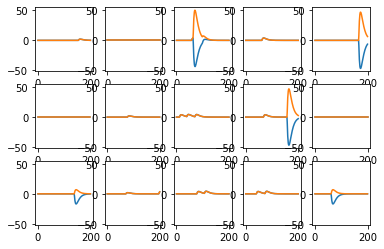

In [16]:
out, other_recordings = simple_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

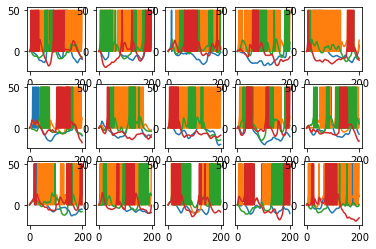

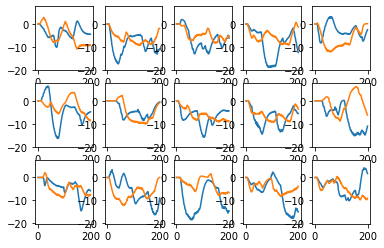

In [16]:
out, other_recordings = recurrent_net.run_snn(x_data)

plot_voltage_traces(other_recordings['hidden_soma'], other_recordings['hidden_soma_spike'])
plt.show()
plot_voltage_traces(out)
plt.show()

In [11]:
output,other_recordings = net.run_snn(x_data)
mem_rec, spk_rec = other_recordings['hidden_soma'], other_recordings['hidden_soma_spike']

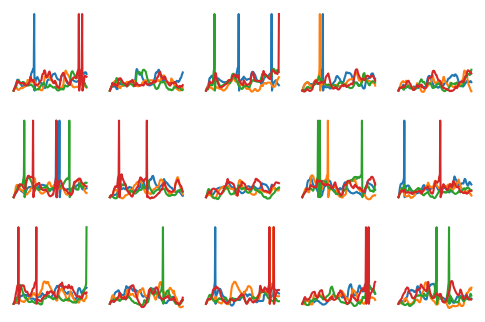

In [12]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

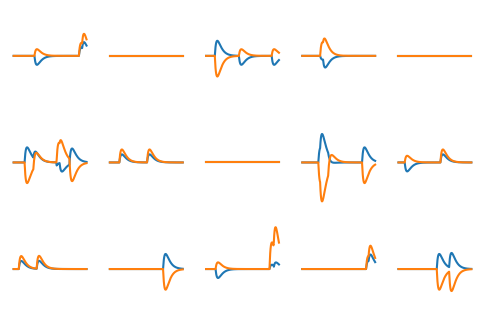

In [13]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

$$z_{dend}^{(l)}(t+1)={\alpha}z_{dend}(t) + \sum_{j}WS_j^{(l-1)} + {\gamma}S_{i}^{(l)}$$

$$z_{soma}^{(l)}(t+1)=\left({\beta}z_{soma}(t) + \sigma(z_{dend}^{(l)})\right)\left(1-S_{i}^{(l)}\right)$$

$$S_{i}^{(l)}(t)=\Theta(z_{soma}^{(l)}(t)-\text{thresh})$$

$$\alpha=exp\left(\frac{-\Delta{t}}{\tau_{dend}}\right)$$
$$\beta=exp\left(\frac{-\Delta{t}}{\tau_{soma}}\right)$$